In [1]:
%matplotlib inline
import os

import intake
import satsearch
from satsearch import Search

import ast
import pandas as pd
import numpy as np
import xarray as xr

import geopandas as gpd
import rasterio
import rioxarray

import dask
from dask.diagnostics import ProgressBar
#import dask.distributed

#import geoviews as gv
#import hvplot.pandas
from ipywidgets import interact
from IPython.display import display, Image


In [2]:
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='250000000',
           GDAL_SWATH_SIZE='250000000',
           VSI_CURL_CACHE_SIZE='250000000')
os.environ.update(env)

In [3]:
bbox = [129.0000000000000000,-39.0000000000000000, 141.0000000000000000,-26.0000000000000000]

dates = '2020-01-01/2020-12-31'

URL='https://earth-search.aws.element84.com/v0'
results = satsearch.Search.search(url=URL,
                                  collections=['sentinel-s2-l2a-cogs'], # note collection='sentinel-s2-l2a-cogs' doesn't work
                                  datetime=dates,
                                  bbox=bbox,   
                                  #property=["eo:cloud_cover<1"],
                                  #query={'eo:cloud_cover': {'lt': 1}},
                                  query={'eo:cloud_cover': {'eq': 0}, 'platform':{'eq': 'sentinel-2a'}, 'sentinel:utm_zone':{'eq': '52'}  },
                                  
                                  sort=['<datetime'])

In [7]:
savefile = 'my-s2-l2a-cogs-sa-cloudcover0SA-52.geojson'
print('%s items' % results.found())
items = results.items()
# Save this locally for use later
#items.save('my-s2-l2a-cogs-sa-cloudcover1.json')
items.save(savefile)

718 items


In [8]:
catalog = intake.open_stac_item_collection(results.items())

In [9]:
import geopandas as gpd
gf2 = gpd.read_file(savefile)

In [10]:
gf2.head()

,id,datetime,platform,constellation,gsd,view:off_nadir,proj:epsg,sentinel:utm_zone,sentinel:latitude_band,sentinel:grid_square,sentinel:sequence,sentinel:product_id,sentinel:data_coverage,eo:cloud_cover,sentinel:valid_cloud_cover,created,updated,data_coverage,geometry
0,S2A_52HFJ_20201226_0_L2A,2020-12-26T01:16:33+00:00,sentinel-2a,sentinel-2,10,0,32752,52,H,FJ,0,S2A_MSIL2A_20201226T010731_N0214_R045_T52HFJ_2...,3.06,0,True,2020-12-26T06:10:39.370998+00:00,2020-12-26T06:10:39.370998+00:00,NaN,"POLYGON ((131.25157 -33.31681, 131.10233 -33.2..."
1,S2A_52JGM_20201226_0_L2A,2020-12-26T01:15:46+00:00,sentinel-2a,sentinel-2,10,0,32752,52,J,GM,0,S2A_MSIL2A_20201226T010731_N0214_R045_T52JGM_2...,19.68,0,True,2020-12-26T06:12:23.707001+00:00,2020-12-26T06:12:23.707001+00:00,NaN,"POLYGON ((131.85040 -30.78996, 132.13995 -29.7..."
2,S2A_52JDP_20201222_0_L2A,2020-12-22T01:35:18+00:00,sentinel-2a,sentinel-2,10,0,32752,52,J,DP,0,S2A_MSIL2A_20201222T012721_N0214_R131_T52JDP_2...,100.00,0,True,2020-12-22T06:26:24.480000+00:00,2020-12-22T06:26:24.480000+00:00,NaN,"POLYGON ((129.10021 -29.01597, 127.97281 -29.0..."
3,S2A_52JEP_20201222_0_L2A,2020-12-22T01:35:15+00:00,sentinel-2a,sentinel-2,10,0,32752,52,J,EP,0,S2A_MSIL2A_20201222T012721_N0214_R131_T52JEP_2...,100.00,0,True,2020-12-22T06:39:17.584000+00:00,2020-12-22T06:39:17.584000+00:00,NaN,"POLYGON ((128.99980 -29.01601, 128.99981 -28.0..."
4,S2A_52JFP_20201222_0_L2A,2020-12-22T01:35:11+00:00,sentinel-2a,sentinel-2,10,0,32752,52,J,FP,0,S2A_MSIL2A_20201222T012721_N0214_R131_T52JFP_2...,49.84,0,True,2020-12-22T06:27:39.548000+00:00,2020-12-22T06:27:39.548000+00:00,NaN,"POLYGON ((130.02680 -29.01208, 130.01724 -28.0..."


In [11]:
def get_STAC_items(url, collection, dates, bbox):
    results = Search.search(url=url,
                        collections=[collection], 
                        datetime=dates,
                        bbox=bbox,    
                        query={'eo:cloud_cover': {'eq': 0}, 'platform':{'eq': 'sentinel-2a'}, 'sentinel:utm_zone':{'eq': '52'} },
                        sortby=['-properties.datetime'])

    items = results.items()
    print(f'Found {len(items)} Items')
    
    return intake.open_stac_item_collection(items)

In [12]:
URL2='https://earth-search.aws.element84.com/v0'
collection2 = 'sentinel-s2-l2a-cogs' # sentinel-2 w/ atmospheric corrections
items_s2 = get_STAC_items(URL2, collection2, dates, bbox)


Found 10000 Items


In [13]:
gf2function = items_s2.to_geopandas()

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
gf2function.head()

,geometry,datetime,platform,constellation,instruments,gsd,view:off_nadir,proj:epsg,sentinel:utm_zone,sentinel:latitude_band,sentinel:grid_square,sentinel:sequence,sentinel:product_id,sentinel:data_coverage,eo:cloud_cover,sentinel:valid_cloud_cover,created,updated,data_coverage
0,"POLYGON ((131.25157 -33.31681, 131.10233 -33.2...",2020-12-26T01:16:33Z,sentinel-2a,sentinel-2,[msi],10,0,32752,52,H,FJ,0,S2A_MSIL2A_20201226T010731_N0214_R045_T52HFJ_2...,3.06,0,True,2020-12-26T06:10:39.371Z,2020-12-26T06:10:39.371Z,NaN
1,"POLYGON ((131.85040 -30.78996, 132.13995 -29.7...",2020-12-26T01:15:46Z,sentinel-2a,sentinel-2,[msi],10,0,32752,52,J,GM,0,S2A_MSIL2A_20201226T010731_N0214_R045_T52JGM_2...,19.68,0,True,2020-12-26T06:12:23.707Z,2020-12-26T06:12:23.707Z,NaN
2,"POLYGON ((129.10021 -29.01597, 127.97281 -29.0...",2020-12-22T01:35:18Z,sentinel-2a,sentinel-2,[msi],10,0,32752,52,J,DP,0,S2A_MSIL2A_20201222T012721_N0214_R131_T52JDP_2...,100.00,0,True,2020-12-22T06:26:24.480Z,2020-12-22T06:26:24.480Z,NaN
3,"POLYGON ((128.99980 -29.01601, 128.99981 -28.0...",2020-12-22T01:35:15Z,sentinel-2a,sentinel-2,[msi],10,0,32752,52,J,EP,0,S2A_MSIL2A_20201222T012721_N0214_R131_T52JEP_2...,100.00,0,True,2020-12-22T06:39:17.584Z,2020-12-22T06:39:17.584Z,NaN
4,"POLYGON ((130.02680 -29.01208, 130.01724 -28.0...",2020-12-22T01:35:11Z,sentinel-2a,sentinel-2,[msi],10,0,32752,52,J,FP,0,S2A_MSIL2A_20201222T012721_N0214_R131_T52JFP_2...,49.84,0,True,2020-12-22T06:27:39.548Z,2020-12-22T06:27:39.548Z,NaN


In [15]:
%%time

# First let's construct a large dataset with all the scenes in our search so that we
# have a time dimension
# Loop through geopandas geodataframe (each row is a STAC ITEM)
import dask

@dask.delayed
def stacitem_to_dataset2(item, datetimeuse):
    print(item)
    #stacked = catalog[item.id].stack_bands(bands)
    #stacked = item.stack_bands(['B02','B03','B04','B05'])
    stacked = item.stack_bands(['B02'])
    da = stacked(chunks=dict(band=1, x=2048, y=2048)).to_dask()
    #da = stacked(chunks=dict(band=1, x=5120, y=5120)).to_dask()
    #da['band'] = bands # use common names
    #da['band'] = ['blue','green','red','nir'] # use common names
    da['band'] = ['blue'] # use common names
    da = da.expand_dims(time=[pd.to_datetime(datetimeuse)])
    #da = stacked(chunks=dict(band=1, x=5120, y=5120, time=-1)).to_dask()
    ds = da.to_dataset(dim='band')
    return ds

lazy_datasets = []
#for i,item in gf.iterrows():
#for i,item in gf.head(1).iterrows():   

for index, x in enumerate(items_s2):
    #need to make items_s2
    #need to get datetime from the dataframe gf2 as well
    datetimeuse = gf2function.iloc[index]['datetime']
    itemx = items_s2[x]
    ds = stacitem_to_dataset2(itemx, datetimeuse)
    lazy_datasets.append(ds)



Wall time: 674 ms


In [16]:
print(len(lazy_datasets))

500


In [20]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    datasets = dask.compute(*lazy_datasets)
datasets    

[                                        ] | 0% Completed |  0.0s<Intake catalog: S2A_52JFN_20200702_0_L2A>
<Intake catalog: S2A_52JFS_20200831_0_L2A>
<Intake catalog: S2A_52JEL_20200913_0_L2A>
<Intake catalog: S2A_52JEL_20200615_0_L2A>
<Intake catalog: S2A_52JGR_20201102_0_L2A>
<Intake catalog: S2A_52JFQ_20201112_0_L2A>
<Intake catalog: S2A_52JGL_20200831_0_L2A>
<Intake catalog: S2A_52JGN_20201010_0_L2A>
<Intake catalog: S2A_52JGQ_20201020_0_L2A>
<Intake catalog: S2A_52JFQ_20201102_0_L2A>
<Intake catalog: S2A_52JFS_20200622_0_L2A>
<Intake catalog: S2A_52JGR_20200702_0_L2A>
[                                        ] | 0% Completed | 18.9s<Intake catalog: S2A_52JEM_20200824_0_L2A>
<Intake catalog: S2A_52JGM_20201116_0_L2A><Intake catalog: S2A_52JGN_20200702_0_L2A>

<Intake catalog: S2A_52JEM_20200702_0_L2A>
<Intake catalog: S2A_52JDP_20200516_0_L2A>
<Intake catalog: S2A_52HEJ_20201209_0_L2A>
<Intake catalog: S2A_52JFM_20200715_0_L2A>
<Intake catalog: S2A_52JFN_20201202_0_L2A>
[         

[###########                             ] | 28% Completed |  3min 27.2s<Intake catalog: S2A_52JEN_20200903_0_L2A>
<Intake catalog: S2A_52JFM_20200705_0_L2A>
<Intake catalog: S2A_52JEM_20201202_0_L2A><Intake catalog: S2A_52JDS_20200705_0_L2A>

<Intake catalog: S2A_52JFS_20201010_0_L2A><Intake catalog: S2A_52JEN_20200722_0_L2A>

[###########                             ] | 28% Completed |  3min 43.6s<Intake catalog: S2A_52JFQ_20200801_1_L2A>
<Intake catalog: S2A_52JFM_20200913_0_L2A>
<Intake catalog: S2A_52JFQ_20200602_1_L2A>
<Intake catalog: S2A_52JDS_20200605_0_L2A><Intake catalog: S2A_52HEK_20200605_0_L2A>

[############                            ] | 30% Completed |  3min 43.8s<Intake catalog: S2A_52JFQ_20200831_0_L2A>
<Intake catalog: S2A_52JGN_20201030_0_L2A>
<Intake catalog: S2A_52JEQ_20201112_0_L2A>
<Intake catalog: S2A_52JGQ_20200920_0_L2A><Intake catalog: S2A_52JEP_20200523_0_L2A>

<Intake catalog: S2A_52JFQ_20201030_0_L2A>
<Intake catalog: S2A_52JGR_20200715_0_L2A>
[#########

[#######################                 ] | 57% Completed |  7min 12.0s<Intake catalog: S2A_52HFJ_20200831_0_L2A><Intake catalog: S2A_52JFR_20201020_0_L2A>
<Intake catalog: S2A_52JGR_20200523_0_L2A>
<Intake catalog: S2A_52JFS_20201020_0_L2A>

<Intake catalog: S2A_52JFP_20200715_0_L2A>
[#######################                 ] | 58% Completed |  7min 12.2s<Intake catalog: S2A_52JGM_20201109_0_L2A>
<Intake catalog: S2A_52JEP_20201222_0_L2A>
<Intake catalog: S2A_52JGQ_20200831_0_L2A>
<Intake catalog: S2A_52JFR_20201030_0_L2A><Intake catalog: S2A_52JFQ_20200903_0_L2A>

<Intake catalog: S2A_52JFN_20200923_0_L2A><Intake catalog: S2A_52JEP_20200722_0_L2A>

[########################                ] | 60% Completed |  7min 29.3s<Intake catalog: S2A_52JEQ_20200705_0_L2A>
<Intake catalog: S2A_52JFQ_20200722_0_L2A>
<Intake catalog: S2A_52JFQ_20200612_0_L2A>
<Intake catalog: S2A_52JEL_20200516_0_L2A><Intake catalog: S2A_52JGQ_20201030_0_L2A>

[########################                ] | 61% Comp

[##################################      ] | 87% Completed | 10min 39.2s
<Intake catalog: S2A_52JEL_20200605_0_L2A>
<Intake catalog: S2A_52JDS_20200824_0_L2A>
<Intake catalog: S2A_52JFS_20200722_0_L2A>
<Intake catalog: S2A_52JDN_20200913_0_L2A>
<Intake catalog: S2A_52JEM_20200615_0_L2A><Intake catalog: S2A_52JFQ_20201020_0_L2A>
<Intake catalog: S2A_52HGH_20201116_0_L2A>

<Intake catalog: S2A_52JFQ_20200523_0_L2A>
<Intake catalog: S2A_52JGP_20201010_0_L2A>
[###################################     ] | 88% Completed | 10min 39.3s<Intake catalog: S2A_52JGP_20200602_0_L2A>
[###################################     ] | 89% Completed | 10min 57.2s<Intake catalog: S2A_52JGM_20200619_0_L2A>
<Intake catalog: S2A_52JDS_20200923_0_L2A>
<Intake catalog: S2A_52JGR_20200615_0_L2A><Intake catalog: S2A_52JFN_20200930_0_L2A>

<Intake catalog: S2A_52JEQ_20200605_0_L2A><Intake catalog: S2A_52JDQ_20200725_0_L2A><Intake catalog: S2A_52HEJ_20200811_0_L2A>


<Intake catalog: S2A_52JDN_20200605_0_L2A>
<Intake c

(<xarray.Dataset>
 Dimensions:  (time: 1, x: 10980, y: 10980)
 Coordinates:
   * time     (time) object 2020-12-26T01:16:33+00:00
   * y        (y) float64 6.4e+06 6.4e+06 6.4e+06 ... 6.29e+06 6.29e+06 6.29e+06
   * x        (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
 Data variables:
     blue     (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
 Attributes:
     transform:           (10.0, 0.0, 600000.0, 0.0, -10.0, 6400000.0)
     crs:                 +init=epsg:32752
     res:                 (10.0, 10.0)
     is_tiled:            1
     nodatavals:          (0.0,)
     scales:              (1.0,)
     offsets:             (0.0,)
     AREA_OR_POINT:       Area
     OVR_RESAMPLING_ALG:  AVERAGE,
 <xarray.Dataset>
 Dimensions:  (time: 1, x: 10980, y: 10980)
 Coordinates:
   * time     (time) object 2020-12-26T01:15:46+00:00
   * y        (y) float64 6.7e+06 6.7e+06 6.7e+06 ... 6.59e+06 6.59e+06 6.59e+06
   * x        (x) float64 7e+05 7e+

In [21]:
DS = xr.concat(datasets, dim='time')

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': 

In [25]:
print(DS.nbytes/1e9)
DS

11.167377264


,Array,Chunk
Bytes,20.59 TB,33.55 MB
Shape,"(500, 100980, 50982)","(1, 2048, 2048)"
Count,2109974 Tasks,663000 Chunks
Type,float64,numpy.ndarray


In [26]:
def median(array, dim, keep_attrs=False, skipna=False, **kwargs):
    """ Runs a median on an dask-backed xarray.
    
    This function does not scale!
    It will rechunk along the given dimension, so make sure 
    your other chunk sizes are small enough that it 
    will fit into memory.
    
    :param DataArray array: An xarray.DataArray wrapping a dask array
    :param dim str: The name of the dim in array to calculate the median
    """
    if type(array) is xr.Dataset:
        return array.apply(median, dim=dim, keep_attrs=keep_attrs, **kwargs)
    
    if not hasattr(array.data, 'dask'):
        return array.median(dim, keep_attrs=keep_attrs, **kwargs)
    
    array = array.chunk({dim:-1})
    axis = array.dims.index(dim)
    median_func = np.nanmedian if skipna else np.median
    blocks = dask.array.map_blocks(median_func, array.data, dtype=array.dtype, drop_axis=axis, axis=axis, **kwargs)
    
    new_coords={k: v for k, v in array.coords.items() if k != dim and dim not in v.dims}
    new_dims = tuple(d for d in array.dims if d != dim)
    new_attrs = array.attrs if keep_attrs else None
    
    return xr.DataArray(blocks, coords=new_coords, dims=new_dims, attrs=new_attrs)

In [27]:
DS['blue']

,Array,Chunk
Bytes,20.59 TB,33.55 MB
Shape,"(500, 100980, 50982)","(1, 2048, 2048)"
Count,2109974 Tasks,663000 Chunks
Type,float64,numpy.ndarray


In [28]:
blue_median = median(DS.blue, dim='time')

In [29]:
blue_median

<xarray.DataArray 'median-f3d830043e676b18f25ef2e82bb08dba' (y: 100980, x: 50982)>
dask.array<median, shape=(100980, 50982), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 4e+05 4e+05 4e+05 ... 9.098e+05 9.098e+05 9.098e+05
  * y        (y) float64 6.19e+06 6.19e+06 6.19e+06 ... 7.2e+06 7.2e+06 7.2e+06

In [67]:
blue_mean = DS['blue'].mean(dim='time')

In [ ]:
blue_mean

In [23]:
with ProgressBar():

    bluemedianNP = blue_median.compute()
    #bluemeanNP = blue_mean.compute()

[########################################] | 100% Completed |  1hr 24min 21.6s


In [24]:
import rioxarray
#blue_median.rio.to_raster("C:/users/rscott/Downloads/blue_median.tif")

In [75]:
#blue_median.rio.write_crs('EPSG:32754', inplace=True)
#blue_median.rio.to_raster("C:/users/rscott/Downloads/blue_median20pth5.tif")
bluemedianNP.rio.write_crs('EPSG:32754', inplace=True)
#bluemedianNP.rio.to_raster("C:/users/rscott/Downloads/blue_medianOZ.tif")

<xarray.DataArray 'median-8d32d5f5f58296f25583e94cf808a8aa' (y: 10980, x: 10980)>
array([[  0. ,   0. ,   0. , ..., 632.5, 599. , 611.5],
       [  0. ,   0. ,   0. , ..., 491. , 505.5, 459.5],
       [  0. ,   0. ,   0. , ..., 582.5, 718. , 585. ],
       ...,
       [  0. ,   0. ,   0. , ..., 268. , 227.5, 235. ],
       [  0. ,   0. ,   0. , ..., 262.5, 237.5, 265.5],
       [  0. ,   0. ,   0. , ..., 268.5, 266. , 263.5]])
Coordinates:
  * y            (y) float64 6.2e+06 6.2e+06 6.2e+06 ... 6.09e+06 6.09e+06
  * x            (x) float64 2e+05 2e+05 2e+05 ... 3.098e+05 3.098e+05 3.098e+05
    spatial_ref  int32 0
Attributes:
    grid_mapping:  spatial_ref

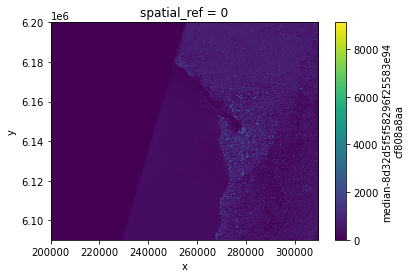

In [41]:
bluemedianNP.plot.imshow();

In [144]:
sentinel_good = ['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12']

In [50]:
def median4(sentinelDS):
    blue_median = median(sentinelDS.blue, dim='time')
    green_median = median(sentinelDS.green, dim='time')
    red_median = median(sentinelDS.red, dim='time')
    nir_median = median(sentinelDS.nir, dim='time')
    
    return (blue_median, green_median, red_median, nir_median)

In [51]:
blue_median, green_median, red_median, nir_median = median4(DS4)
with ProgressBar():
    blue_medianNP = blue_median.compute()
    green_medianNP = green_median.compute()
    red_medianNP = red_median.compute()
    nir_medianNP = nir_median.compute()

[########################################] | 100% Completed |  1hr 30min  9.0s
[########################################] | 100% Completed |  1hr 27min 52.5s
[########################################] | 100% Completed |  1hr 39min  2.3s
[########################################] | 100% Completed |  1hr 21min 50.3s


In [56]:
rasters = [blue_medianNP, green_medianNP, red_medianNP, nir_medianNP]
rasters = [green_medianNP, red_medianNP, nir_medianNP]
raster_files = ['blue_medianOZ.tif','green_medianOZ.tif','red_medianOZ.tif','nir_medianOZ.tif']

for index, rasterNP in enumerate(rasters):
    rasterNP.rio.write_crs('ESPG:32754', inplace=True)
    #rasterNP.rio.to_raster(r"H:\Copa de Cobre" + "\\" + raster_files[index])

CRSError: Invalid projection: ESPG:32754: (Internal Proj Error: proj_create: crs not found)

In [59]:
%%time

# First let's construct a large dataset with all the scenes in our search so that we
# have a time dimension
# Loop through geopandas geodataframe (each row is a STAC ITEM)
import dask

@dask.delayed
def stacitem_to_dataset3(item, datetimeuse):
    print(item)
    #stacked = catalog[item.id].stack_bands(bands)
    stacked = item.stack_bands(['B05','B06','B07','B8A','B11','B12'])
    da6 = stacked(chunks=dict(band=1, x=2048, y=2048)).to_dask()
    da6['band'] = ['B05','B06','B07','B8A','B11','B12'] # use common names
    da6 = da6.expand_dims(time=[pd.to_datetime(datetimeuse)])
    ds6 = da6.to_dataset(dim='band')
    return ds6

lazy_datasets6 = []
#for i,item in gf.iterrows():
#for i,item in gf.head(1).iterrows():   

for index, x in enumerate(items_s2):
    #need to make items_s2
    #need to get datetime from the dataframe gf2 as well
    datetimeuse = gf2function.iloc[index]['datetime']
    itemx = items_s2[x]
    ds6 = stacitem_to_dataset3(itemx, datetimeuse)
    lazy_datasets6.append(ds6)

from dask.diagnostics import ProgressBar
with ProgressBar():
    #out = dask.compute(*lazy_datasets)
    
#datasets = dask.compute(*lazy_datasets).mean(dim='time')
    datasets6 = dask.compute(*lazy_datasets6)

[                                        ] | 0% Completed |  0.0s<Intake catalog: S2A_54HTG_20200204_0_L2A>
<Intake catalog: S2A_54HTG_20190120_0_L2A>
<Intake catalog: S2A_54HTG_20190517_0_L2A>
<Intake catalog: S2A_54HTG_20191216_0_L2A>
<Intake catalog: S2A_54HTG_20170308_0_L2A>
<Intake catalog: S2A_54HTG_20190709_0_L2A>
[                                        ] | 0% Completed |  0.1s<Intake catalog: S2A_54HTG_20190226_0_L2A>
<Intake catalog: S2A_54HTG_20170127_0_L2A>
<Intake catalog: S2A_54HTG_20200112_0_L2A>
<Intake catalog: S2A_54HTG_20170619_0_L2A><Intake catalog: S2A_54HTG_20180323_0_L2A>
<Intake catalog: S2A_54HTG_20200610_0_L2A>

[                                        ] | 0% Completed |  1min 34.3s<Intake catalog: S2A_54HTG_20191024_0_L2A>
[#                                       ] | 2% Completed |  1min 36.1s<Intake catalog: S2A_54HTG_20201117_0_L2A>
<Intake catalog: S2A_54HTG_20181118_0_L2A>
<Intake catalog: S2A_54HTG_20200723_0_L2A><Intake catalog: S2A_54HTG_20190914_0_L2A

In [71]:
def median6(sentinelDS):
    b05_median = median(sentinelDS.B05, dim='time')
    b06_median = median(sentinelDS.B06, dim='time')
    b07_median = median(sentinelDS.B07, dim='time')
    b08a_median = median(sentinelDS.B8A, dim='time')
    b11_median = median(sentinelDS.B11, dim='time')
    b12_median = median(sentinelDS.B12, dim='time')
    
    return (b05_median, b06_median, b07_median, b08a_median, b11_median, b12_median)

In [72]:
DS6 = xarray.concat(datasets6, dim='time')

In [73]:
DS6

<xarray.Dataset>
Dimensions:  (time: 40, x: 5490, y: 5490)
Coordinates:
  * time     (time) object 1608425803000000000 ... 1485477763000000000
  * y        (y) float64 6.2e+06 6.2e+06 6.2e+06 ... 6.09e+06 6.09e+06 6.09e+06
  * x        (x) float64 2e+05 2e+05 2e+05 ... 3.097e+05 3.098e+05 3.098e+05
Data variables:
    B05      (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B06      (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B07      (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A      (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B11      (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12      (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    transform:           (20.0, 0.0, 199980.0, 0.0, -20.0, 6200020.0)
    crs:                 +init=epsg:32754
    res:                 (20.0, 20.0)
    is_tiled:            1
    nodatavals:          (0.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE

In [74]:
b05_median, b06_median, b07_median, b08a_median, b11_median, b12_median = median6(DS6)
with ProgressBar():
    b05_medianNP = b05_median.compute()
    b06_medianNP = b06_median.compute()
    b07_medianNP = b07_median.compute()
    b08a_medianNP = b08a_median.compute()
    b11_medianNP = b11_median.compute()
    b12_medianNP = b12_median.compute()


[########################################] | 100% Completed | 18min 44.7s
[########################################] | 100% Completed | 19min 35.5s
[########################################] | 100% Completed | 19min 44.7s
[########################################] | 100% Completed | 19min 47.2s
[########################################] | 100% Completed | 20min 45.8s
[########################################] | 100% Completed | 19min 41.6s


In [79]:
rasters6 = [b05_medianNP, b06_medianNP, b07_medianNP, b08a_medianNP, b11_medianNP, b12_medianNP]
raster_files6 = ['b05_medianOZ.tif','b06_medianOZ.tif','b07_medianOZ.tif','b8a_medianOZ.tif','b11_medianOZ.tif','b12_medianOZ.tif']

import rasterio
import rioxarray

for index, rasterNP in enumerate(rasters6):
    #rasterNP.rio.write_crs('ESPG:32754', inplace=True)
    rasterNP.rio.to_raster(r"H:\Copa de Cobre" + "\\" + raster_files6[index])

In [31]:
%%time

lazy_datasets512 = []

for index, x in enumerate(items_s2):
    datetimeuse = gf2function.iloc[index]['datetime']
    itemx = items_s2[x]
    ds512 = stacitem_to_dataset2(itemx, datetimeuse)
    lazy_datasets512.append(ds512)



Wall time: 828 ms


In [32]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    datasets512 = dask.compute(*lazy_datasets512)
#datasets    

[                                        ] | 0% Completed |  0.0s<Intake catalog: S2A_52JFP_20200910_0_L2A>
<Intake catalog: S2A_52JFS_20200612_0_L2A>
<Intake catalog: S2A_52JEL_20200831_0_L2A><Intake catalog: S2A_52JFN_20200715_0_L2A><Intake catalog: S2A_52JFN_20200923_0_L2A><Intake catalog: S2A_52JFR_20200715_0_L2A>

<Intake catalog: S2A_52JEP_20201030_0_L2A>

<Intake catalog: S2A_52JFS_20200824_0_L2A><Intake catalog: S2A_52JGS_20200705_0_L2A>


<Intake catalog: S2A_52HDH_20200824_0_L2A>
[                                        ] | 0% Completed |  0.1s<Intake catalog: S2A_52JEM_20201119_0_L2A>
<Intake catalog: S2A_52HGJ_20200609_0_L2A>
<Intake catalog: S2A_52HFJ_20201226_0_L2A>
<Intake catalog: S2A_52JEP_20201202_0_L2A>
<Intake catalog: S2A_52JGQ_20200811_0_L2A>
[                                        ] | 0% Completed |  0.3s<Intake catalog: S2A_52JGL_20201116_0_L2A>
<Intake catalog: S2A_52JEL_20200821_0_L2A>
<Intake catalog: S2A_52JDQ_20200625_0_L2A>
<Intake catalog: S2A_52JFS_2020

<Intake catalog: S2A_52JFN_20200702_0_L2A>
[##########                              ] | 25% Completed |  3.9s<Intake catalog: S2A_52JGR_20200814_0_L2A>
<Intake catalog: S2A_52JFR_20200831_0_L2A>
<Intake catalog: S2A_52JEN_20200516_0_L2A>
<Intake catalog: S2A_52HFJ_20200821_0_L2A>
[##########                              ] | 25% Completed |  4.0s<Intake catalog: S2A_52JGL_20200629_0_L2A>
<Intake catalog: S2A_52JES_20200903_0_L2A>
<Intake catalog: S2A_52JDN_20200913_0_L2A>
[##########                              ] | 26% Completed |  4.1s<Intake catalog: S2A_52HEJ_20201209_0_L2A>
<Intake catalog: S2A_52JEP_20200824_0_L2A>
<Intake catalog: S2A_52JGP_20200910_0_L2A>
<Intake catalog: S2A_52JFR_20200605_0_L2A>
[##########                              ] | 27% Completed |  4.2s<Intake catalog: S2A_52JGR_20200824_0_L2A>
<Intake catalog: S2A_52JFQ_20201010_1_L2A>
<Intake catalog: S2A_52HEJ_20200705_1_L2A>
<Intake catalog: S2A_52JEN_20200705_0_L2A>
[###########                             ] | 28%

[####################                    ] | 50% Completed |  8.2s<Intake catalog: S2A_52JDP_20201222_0_L2A>
<Intake catalog: S2A_52JGQ_20200930_0_L2A>
[####################                    ] | 50% Completed |  8.3s<Intake catalog: S2A_52JFP_20200705_0_L2A>
<Intake catalog: S2A_52JGQ_20200801_0_L2A>
<Intake catalog: S2A_52JGQ_20200910_0_L2A>
[####################                    ] | 51% Completed |  8.4s<Intake catalog: S2A_52JGS_20200605_0_L2A>
<Intake catalog: S2A_52HEJ_20200811_0_L2A>
<Intake catalog: S2A_52JGN_20201129_0_L2A>
[####################                    ] | 52% Completed |  8.5s<Intake catalog: S2A_52HGJ_20200609_1_L2A>
<Intake catalog: S2A_52JEP_20200722_0_L2A>
<Intake catalog: S2A_52JFQ_20200602_1_L2A>
[#####################                   ] | 52% Completed |  8.7s<Intake catalog: S2A_52JGM_20200920_0_L2A>
<Intake catalog: S2A_52JEQ_20200923_0_L2A>
<Intake catalog: S2A_52JDS_20200903_0_L2A>
[#####################                   ] | 53% Completed |  8.8s<I

[##############################          ] | 75% Completed | 12.8s<Intake catalog: S2A_52JFN_20200605_1_L2A>
<Intake catalog: S2A_52JER_20200725_0_L2A>
<Intake catalog: S2A_52JGQ_20201010_0_L2A>
[##############################          ] | 76% Completed | 12.9s<Intake catalog: S2A_52JEM_20200824_0_L2A>
<Intake catalog: S2A_52JEN_20201112_0_L2A>
<Intake catalog: S2A_52JDS_20200705_0_L2A>
[##############################          ] | 77% Completed | 13.0s<Intake catalog: S2A_52JEP_20201129_0_L2A>
<Intake catalog: S2A_52JEP_20200705_0_L2A>
[##############################          ] | 77% Completed | 13.1s<Intake catalog: S2A_52JER_20201222_0_L2A>
<Intake catalog: S2A_52JER_20200824_0_L2A>
<Intake catalog: S2A_52JDS_20200923_0_L2A>
[###############################         ] | 78% Completed | 13.2s<Intake catalog: S2A_52JGN_20200831_0_L2A>
<Intake catalog: S2A_52JGQ_20201129_0_L2A>
<Intake catalog: S2A_52JFR_20200923_0_L2A>
<Intake catalog: S2A_52JGS_20200920_0_L2A>
[########################

In [34]:
DS512 = xr.concat(datasets512, dim='time')

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\xarray\core\indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-packages\dask\array\core.py:4041: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pangeo\lib\site-pack

In [35]:
DS512

,Array,Chunk
Bytes,20.59 TB,2.10 MB
Shape,"(500, 100980, 50982)","(1, 512, 512)"
Count,35115370 Tasks,11183000 Chunks
Type,float64,numpy.ndarray


In [36]:
DS512['blue']

,Array,Chunk
Bytes,20.59 TB,2.10 MB
Shape,"(500, 100980, 50982)","(1, 512, 512)"
Count,35115370 Tasks,11183000 Chunks
Type,float64,numpy.ndarray


In [38]:
blue_median512 = median(DS512.blue, dim='time')
blue_median512

<xarray.DataArray 'median-a9172f5955bd9be0ca56ecba89db8b90' (y: 100980, x: 50982)>
dask.array<median, shape=(100980, 50982), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 4e+05 4e+05 4e+05 ... 9.098e+05 9.098e+05 9.098e+05
  * y        (y) float64 6.19e+06 6.19e+06 6.19e+06 ... 7.2e+06 7.2e+06 7.2e+06

In [40]:
with ProgressBar():
    bluemedian512NP = blue_median512.compute()
    #DS512blue = DS512['blue'].compute()

[                                        ] | 0% Completed | 22min 42.3s


MemoryError: 